cuda
Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


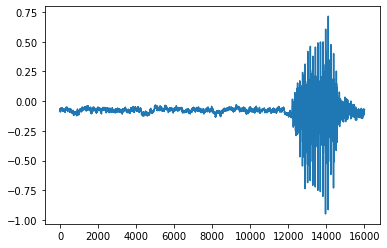

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# 划分训练集与测试集
train_set = SubsetSC("training")
test_set  = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

In [2]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [3]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [4]:
new_sample_rate = 8000
transform   = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [5]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [6]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch] # 将Tensor进行转置
    # 用0填充张量至等长度，.pad_sequence()用法可参考：https://blog.csdn.net/qq_38251616/article/details/125222012
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []
    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

# 关于torch.utils.data.DataLoader()用法不清楚的同学，可以参考文章：
# https://blog.csdn.net/qq_38251616/article/details/125221503
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([256, 1, 16000])
Shape of y:  torch.Size([256]) torch.int64


In [7]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [9]:
# 为加速代码运行，训练过程中不计算准确率。
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data   = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data   = transform(data)
        output = model(data)

        # 计算 loss
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印训练进度
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # 记录 loss
        losses.append(loss.item())
# 计算预测正确的数目
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

# 找到最有可能的标签
def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")
log_interval = 100  # 每100个batch打印一次训练结果
n_epoch = 10

losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test(model, epoch)
    scheduler.step()

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.727110
Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.928219
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.387601
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.109972

Test Epoch: 1	Accuracy: 7139/11005 (65%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.144952
Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.044217
Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.860765
Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.899331

Test Epoch: 2	Accuracy: 7943/11005 (72%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 1.005190
Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.840294
Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.733825
Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.646029

Test Epoch: 3	Accuracy: 8373/11005 (76%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.698359
Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.729612
Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.734927
Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.707412

Test Epoch: 4	Accuracy: 8459/11005 (77%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.651626
Tra

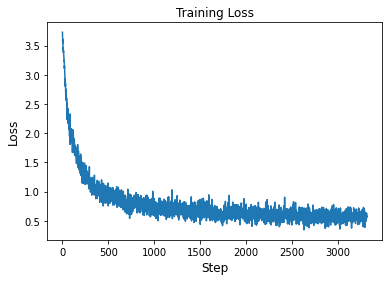

In [10]:
plt.plot(losses)
plt.xlabel("Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss")
plt.show()

In [11]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor
waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)
print(f"真实值: {utterance}. 预测值: {predict(waveform)}.")

真实值: zero. 预测值: zero.


In [12]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. 真实值: {utterance}. 预测值: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. 真实值: {utterance}. 预测值: {output}.")

Data point #1. 真实值: right. 预测值: nine.
